## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

training_file = "train.p"
validation_file= "valid.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image.

### Basic Summary of the Data Set

In [2]:
# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# The shape of an traffic sign image
image_shape = (X_train.shape[1], X_train.shape[2])

# Number of unique classes/labels there are in the dataset
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


### Exploratory visualization of the dataset

In [3]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import random
%matplotlib inline

While the distributions of types of traffic signs in train, valid, and test data are the same in each set, there are very different amounts in each set, which we will need to balance later.

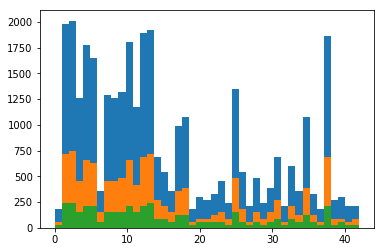

In [4]:
plt.hist(y_train, bins=n_classes) # blue
plt.hist(y_test, bins=n_classes)  # orange
plt.hist(y_valid, bins=n_classes); # green

Sign type: 41


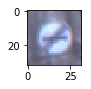

In [5]:
# show random training image
index = random.randint(1, len(X_train))
image = X_train[index]

plt.figure(figsize=(1,1))
plt.imshow(image)
# shows type of traffic sign (see signnames.csv)
print("Sign type:", y_train[index])

----

## Step 2: Design and Test Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

To get a well-fit model, I will preprocess the data with:

- Normalization 
- RGB to grayscale
- An examination of the number of examples per label
- Generation of modified data to balance out classes


My approach for this lab is to begin by implementing a LeNet-5 architecture, [from this paper](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), and continuing on and implementing LeCun and Sermanet's findings [from this paper](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf).

### Pre-process the Data Set (transformation, normalization, grayscale)

In [6]:
# Randomly translate data
# Inspired by https://github.com/vxy10/ImageAugmentation

def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1


def transform_image(img,ang_range,shear_range,trans_range,brightness=0):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over.

    A Random uniform distribution is used to generate different parameters for transformation

    '''
    # Rotation
    ang_rot = np.random.uniform(ang_range) - ang_range/2
    rows, cols, ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2, rows/2), ang_rot, 1)

    # Translation
    tr_x = trans_range*np.random.uniform() - trans_range/2
    tr_y = trans_range*np.random.uniform() - trans_range/2
    Trans_M = np.float32([[1, 0, tr_x], [0, 1, tr_y]])

    # Shear
    pts1 = np.float32([[5, 5], [20, 5], [5, 20]])

    pt1 = 5 + shear_range*np.random.uniform() - shear_range/2
    pt2 = 20 + shear_range*np.random.uniform() - shear_range/2

    # Brightness
    pts2 = np.float32([[pt1, 5], [pt2, pt1], [5, pt2]])

    shear_M = cv2.getAffineTransform(pts1, pts2)

    img = cv2.warpAffine(img, Rot_M, (cols, rows))
    img = cv2.warpAffine(img, Trans_M, (cols, rows))
    img = cv2.warpAffine(img, shear_M, (cols, rows))

    if brightness == 1:
        img = augment_brightness_camera_images(img)

    return img

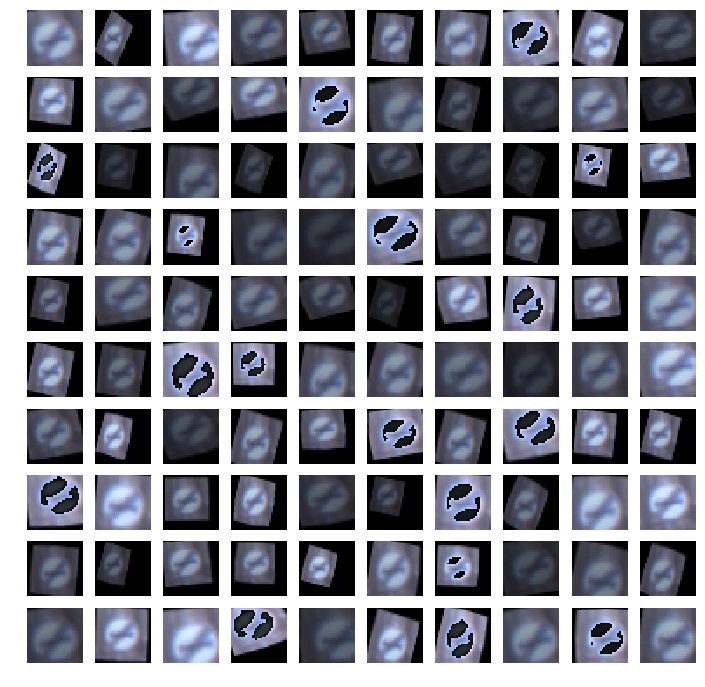

In [7]:
gs1 = gridspec.GridSpec(10, 10)
gs1.update(wspace = 0.01, hspace = 0.02) # set the spacing between axes.
plt.figure(figsize = (12, 12))
for i in range(100):
    ax1 = plt.subplot(gs1[i])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    img = transform_image(image, 20, 10, 5, brightness = 1)

    plt.subplot(10,10, i + 1)
    plt.imshow(img)
    plt.axis('off')

plt.show()

The sign type with the most photos is type 2 with 2010


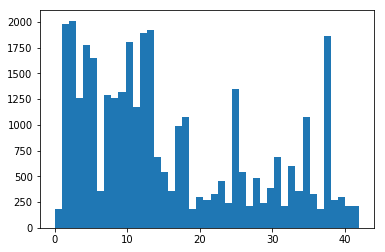

In [8]:
# Which sign has the most data?
y = np.bincount(y_train)
ii = np.nonzero(y)[0]
sign_value_counts = np.vstack((ii,y[ii])).T
max_value_count = max(sign_value_counts[:,1])
print("The sign type with the most photos is type", np.argmax(sign_value_counts[:,1]),
      "with", max(sign_value_counts[:,1]))
plt.hist(y_train, bins=n_classes);

Feel free to use pickled data (two cells down), instead of running the cell below!

In [9]:
# Load pickled data
with open("X_train_w_rand_translations.p", mode='rb') as f:
    X_train = pickle.load(f)
with open("y_train_w_rand_translations.p", mode='rb') as f:
    y_train = pickle.load(f)

Now the data is balanced and ready to be trained on!

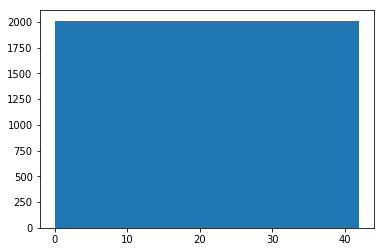

In [10]:
plt.hist(y_train, bins = n_classes);

In [11]:
# Vectorized conversion to grayscale, as specified in openCV docs
# https://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html

def color2gray(colored_img):
    return np.dot(colored_img[...,:3],[0.299,0.587,0.114])

X_train = np.expand_dims(color2gray(X_train.astype(float)), axis=4)
X_valid = np.expand_dims(color2gray(X_valid.astype(float)), axis=4)
X_test = np.expand_dims(color2gray(X_test.astype(float)), axis=4)

In [12]:
# Normalize the data
X_train = (X_train - 128)/128
X_valid = (X_valid - 128)/128
X_test = (X_test - 128)/128

In [13]:
# Shuffle data
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

### Model Architecture

In [14]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from tensorflow.contrib.layers import batch_norm
from tensorflow.contrib.layers import conv2d
from tensorflow.contrib.layers import dropout
from tensorflow.contrib.layers import flatten
from tensorflow.contrib.layers import fully_connected
from tensorflow.contrib.layers import l2_regularizer
from tensorflow.contrib.layers import max_pool2d

## LeNet-5 Architecture

In [15]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    # Output width=((W-F+2*P)/S)+1
    W1 = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    x = tf.nn.conv2d(x, W1, strides=[1, 1, 1, 1], padding='VALID')
    b1 = tf.Variable(tf.zeros(6))
    x = tf.nn.bias_add(x, b1)

    # Activation.
    x = tf.nn.relu(x)
    
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Layer 2: Convolutional. Output = 10x10x16.
    W2 = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    x = tf.nn.conv2d(x, W2, strides=[1, 1, 1, 1], padding='VALID')
    b2 = tf.Variable(tf.zeros(16))
    x = tf.nn.bias_add(x, b2)
                     
    # Activation.
    x = tf.nn.relu(x)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    x = flatten(x)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    W3 = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    b3 = tf.Variable(tf.zeros(120))    
    x = tf.add(tf.matmul(x, W3), b3)
    
    # Activation.
    x = tf.nn.relu(x)
    
    # Dropout
    x = tf.nn.dropout(x, prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    W4 = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    b4 = tf.Variable(tf.zeros(84)) 
    x = tf.add(tf.matmul(x, W4), b4)
    
    # Activation.
    x = tf.nn.relu(x)
    
    # Dropout
    x = tf.nn.dropout(x, prob)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    W5 = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    b5 = tf.Variable(tf.zeros(43)) 
    logits = tf.add(tf.matmul(x, W5), b5)
    
    return logits

## LeCun-Sermanet Architecture

In [16]:
from tensorflow.contrib.layers import flatten

def LeNet_mod(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    W1 = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma), name="W1")
    x = tf.nn.conv2d(x, W1, strides=[1, 1, 1, 1], padding='VALID')
    b1 = tf.Variable(tf.zeros(6), name="b1")
    x = tf.nn.bias_add(x, b1)
   
    # Activation.
    x = tf.nn.relu(x)
    
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    layer1 = x
    
    # Layer 2: Convolutional. Output = 10x10x16.
    W2 = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma), name="W2")
    x = tf.nn.conv2d(x, W2, strides=[1, 1, 1, 1], padding='VALID')
    b2 = tf.Variable(tf.zeros(16), name="b2")
    x = tf.nn.bias_add(x, b2)
                     
    # Activation.
    x = tf.nn.relu(x)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    layer2 = x
    
    # Layer 3: Convolutional. Output = 1x1x400.
    W3 = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 400), mean = mu, stddev = sigma), name="W3")
    x = tf.nn.conv2d(x, W3, strides=[1, 1, 1, 1], padding='VALID')
    b3 = tf.Variable(tf.zeros(400), name="b3")
    x = tf.nn.bias_add(x, b3)
                     
    # Activation.
    x = tf.nn.relu(x)
    layer3 = x

    # Flatten. Input = 5x5x16. Output = 400.
    layer2flat = flatten(layer2)
    
    # Flatten post-convolution x. Input = 1x1x400. Output = 400.
    extra_conv_flat = flatten(x)
    
    # Concat layer2flat and post-convolution layer. Input = 400 + 400. Output = 800
    x = tf.concat([extra_conv_flat, layer2flat], 1)
    
    # Dropout
    x = tf.nn.dropout(x, prob)
    
    # Layer 4: Fully Connected. Input = 800. Output = 43.
    W4 = tf.Variable(tf.truncated_normal(shape=(800, 43), mean = mu, stddev = sigma), name="W4")
    b4 = tf.Variable(tf.zeros(43), name="b4")    
    logits = tf.add(tf.matmul(x, W4), b4)
    
    return logits

### Features and Labels

In [17]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
prob = tf.placeholder(tf.float32)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

### Training Pipeline

In [18]:
rate = 0.001
EPOCHS = 15
BATCH_SIZE = 32

logits = LeNet_mod(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

### Model Validation

In [19]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        
        accuracy = sess.run(accuracy_operation, feed_dict={prob: 1.0, x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train the Model

In [20]:
from sklearn.metrics import log_loss

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={prob: 0.5, x: batch_x, y: batch_y})
            
        training_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Training Accuracy = 0.728
Validation Accuracy = 0.887

EPOCH 2 ...
Training Accuracy = 0.816
Validation Accuracy = 0.921

EPOCH 3 ...
Training Accuracy = 0.873
Validation Accuracy = 0.934

EPOCH 4 ...
Training Accuracy = 0.891
Validation Accuracy = 0.944

EPOCH 5 ...
Training Accuracy = 0.919
Validation Accuracy = 0.961

EPOCH 6 ...
Training Accuracy = 0.926
Validation Accuracy = 0.954

EPOCH 7 ...
Training Accuracy = 0.935
Validation Accuracy = 0.949

EPOCH 8 ...
Training Accuracy = 0.947
Validation Accuracy = 0.960

EPOCH 9 ...
Training Accuracy = 0.947
Validation Accuracy = 0.956

EPOCH 10 ...
Training Accuracy = 0.952
Validation Accuracy = 0.959

EPOCH 11 ...
Training Accuracy = 0.959
Validation Accuracy = 0.955

EPOCH 12 ...
Training Accuracy = 0.960
Validation Accuracy = 0.959

EPOCH 13 ...
Training Accuracy = 0.961
Validation Accuracy = 0.956

EPOCH 14 ...
Training Accuracy = 0.963
Validation Accuracy = 0.956

EPOCH 15 ...
Training Accuracy = 0.968
Valid

### Evaluate the Model

In [21]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.935


### Test Images

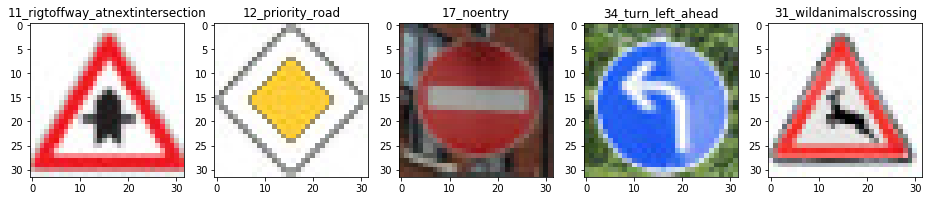

In [22]:
import glob
import matplotlib.image as mpimg

image_names = glob.glob('test_images/*.jpg')
web_images = [mpimg.imread(img_name) for img_name in image_names]
fig, ax = plt.subplots(ncols=len(web_images), figsize=(16, 8))
for ax, image, image_name in zip(ax, web_images, image_names):
    ax.imshow(image)
    ax.set_title(((image_name.split('/')[1]).split('.')[0]).split('_32')[0])

### Preprocessing Pipeline

INFO:tensorflow:Restoring parameters from ./lenet
[11 12 17 34 31]


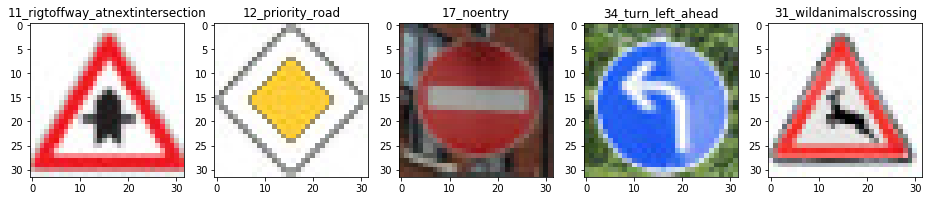

In [23]:
def preprocessing(images):
    output = np.zeros((len(images), 32, 32, 1), np.float64)
    for index, img in enumerate(images):
        gray = np.expand_dims(color2gray(np.array(img).astype(float)), axis=4)
        output[index] = (gray.astype(np.float64) - 128)/128
    return output

processed_web_images = preprocessing(web_images)

prediction = tf.argmax(logits,1)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    predictions = sess.run(prediction, feed_dict={x: processed_web_images, prob: 1.0})
    print(predictions)

fig, ax = plt.subplots(ncols=len(web_images), figsize=(16, 8))
for ax, image, image_name in zip(ax, web_images, image_names):
    ax.imshow(image)
    ax.set_title(((image_name.split('/')[1]).split('.')[0]).split('_32')[0])

As we can see, our model correctly identified each of the five images pulled from the interwebs, scoring higher than the test data.

INFO:tensorflow:Restoring parameters from ./lenet


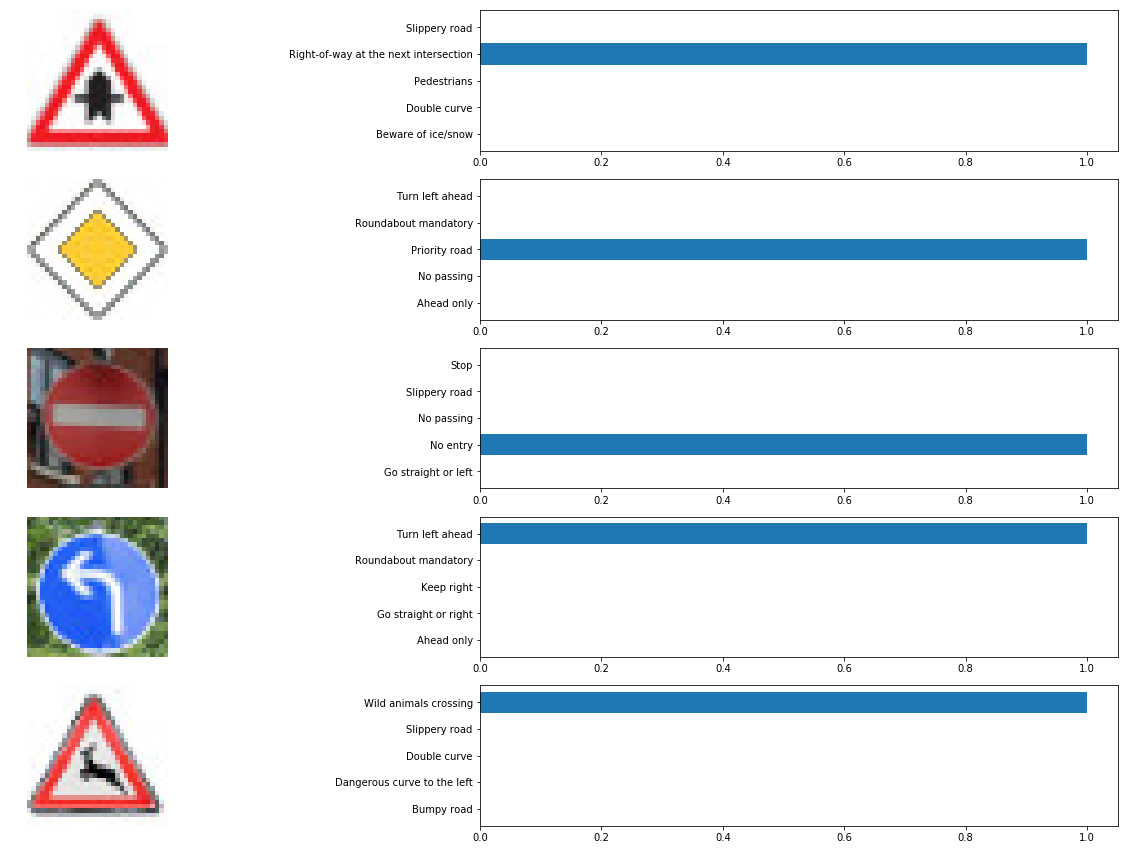

In [24]:
import csv


class_to_sign_type = {}
with open('signnames.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        class_to_sign_type[row[0]] = row[1]
        

def visualize_softmax_probs(test_images, train_images, top_k):
    probabilities = top_k.values
    indices = top_k.indices
    assert (len(test_images) == len(indices))
          
    n_columns = 2
    n_rows = len(indices)
    width = 24
    height = n_rows * 3
    fig, axs = plt.subplots(n_rows,n_columns, figsize=(width, height))
    fig.subplots_adjust(hspace = .2, wspace=.1)
    axs = axs.ravel()
    i = 0
    for row in range(n_rows):
        axs[i].axis('off')
        axs[i].imshow(test_images[row])
        i += 1
        labs = [class_to_sign_type[str(j)] for j in indices[row]]
        axs[i].barh(labs, probabilities[row])
        i += 1


softmax_logits = tf.nn.softmax(logits)
top_k=tf.nn.top_k(softmax_logits,5)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    top_k = sess.run(top_k, feed_dict={x: processed_web_images, prob : 1.0})
    
    visualize_softmax_probs(web_images, X_train, top_k)

Here we see the softmax probabilites for each of the images. As we can see, our algorithm is nearly 100% confident for each of the classifactions.

### Results

LeNet Architecture: (10 epochs)
    Training Accuracy: 0.836
    Validation Accuracy: 0.948
    Test Accuracy: 0.913
    
LeCun-Sermanet:
    Training Accuracy: 0.968
    Validation Accuracy: 0.960
    Test Accuracy: 0.935

Going Forward:

    Test:
        - ELU
        - batch normalization
        - more layers
        - more droupout 
    Also try high speed and accuracy models like:
        - AlexNet (looks much like LeNet, introduced ReLU and dropout)
        - GoogLeNet
        - ResNet
        - VGG
        - SSD
        - Detectron